# Model built using Residual, Senet, and Inception Blocks


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import matplotlib.gridspec as gridspec

np.random.seed(42)
tf.random.set_seed(42);

## ⏳ Load the Data

In [4]:
# Load the training data here
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [5]:
class_name = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [6]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state=seed
)

<h3> Data Normalization and Encoding </h3>
<hr>

In [7]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [8]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9906, 96, 96, 3)
Training Label Shape: (9906, 8)
Validation Data Shape: (2477, 96, 96, 3)
Validation Label Shape: (2477, 8)


In [9]:

# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))
print('Classification: ', class_name[np.argmax(y_train[0])])

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
"Default" label: 0
Classification:  Basophil


<h3> Input and Output Shape </h3>
<hr>

In [10]:
# Determine the input shape, corresponding to the number of features
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

# Determine the output shape, corresponding to the number of classes
output_shape = y_train.shape[1]
print(f'Output shape of the network {output_shape}')

Input shape of the network (96, 96, 3)
Output shape of the network 8


<h3> Other Parameters Definition </h3>
<hr>

In [11]:
# Learning rate?: step size for updating the model's weights
learning_rate = 0.001

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 1000

# Create an empty dictionary to store metadata
metadata = {}

## 🛠️ Train and Save the Model

In [16]:
# Define the Inception block with BN and with multiple convolution paths and optional downsampling
def inception_block_bn(x, filters, kernel_size=3, padding='same',
                       downsample=True, activation='relu', stack=2, name='inception'):
    # Loop through specified stack layers for multiple inception paths
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [17]:
# Define an inception blocks fllowed by SENet block with configurable parameters
def senet_inception_block(x, filters, kernel_size=3, padding='same',
                downsample=True, activation='relu', stack=2, name='senet'):

    for s in range(stack):
        # Main convolutional path
        x = inception_block_bn(x, filters, kernel_size, padding='same',
                   downsample=False, activation='relu', stack=1, name='residual'+name)

        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [18]:
# Define the Residual block with configurable parameters.
# One other architecture trial for the model was to include a inception followed by a senet block in a residual block
def residual_senet_inception_block(x, filters=64, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=2, name='residual_senet_inception'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = senet_inception_block(x, filters, kernel_size=kernel_size, padding='same',
                       downsample=False, activation='relu', stack=1, name='inception'+name)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [19]:
tf.random.set_seed(seed)

# Build the neural network layer by layer
inputs = tfkl.Input(shape=input_shape, name='Input')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip(),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.5),
    tfkl.RandomZoom(0.0, .1),
#    tfkl.RandomBrightness(0.5, value_range=(0,1)),
#    tfkl.RandomContrast(0.75),
], name='Augmentation')

x = augmentation(inputs)

x = residual_senet_inception_block(x, filters=16, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception1')

x = residual_senet_inception_block(x, filters=32, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception2')

x = residual_senet_inception_block(x, filters=64, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception3')

# Global Average Pooling and fully connected output layer
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(0.5, name='dropout')(x)
x = tfkl.Dense(output_shape, name='dense')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [22]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Augmentation           │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_flip       │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomFlip)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_translation     │                      │              │                     │         │
│ (RandomTranslation)    │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_rotation   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomRotation)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_zoom       │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomZoom)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            8 │ Augmentation[0][0]  │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            4 │ Augmentation[0][0]  │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            8 │ residualinceptionr… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            4 │ residualinceptionr… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            0 │ residualinceptionr… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            0 │ residualinceptionr… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 3)    │            0 │ Augmentation[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 10,986 (42.91 KB)

 Trainable params: 10,494 (40.99 KB)

 Non-trainable params: 492 (1.92 KB)

In [23]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [24]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BLOOD_CNN_TEST_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.2693 - loss: 2.2327 - val_accuracy: 0.1328 - val_loss: 2.1808
Epoch 2/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5422 - loss: 1.3101 - val_accuracy: 0.1861 - val_loss: 3.1086
Epoch 3/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6275 - loss: 1.0462 - val_accuracy: 0.1809 - val_loss: 3.7270
Epoch 4/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6812 - loss: 0.8890 - val_accuracy: 0.5176 - val_loss: 1.1547
Epoch 5/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7165 - loss: 0.7761 - val_accuracy: 0.5434 - val_loss: 1.0579
Epoch 6/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7358 - loss: 0.7034 - val_accuracy: 0.5781 - val_loss: 1.8241
Epoch 7/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7627 - loss: 0.6433 - val_accuracy: 0.6480 - val_loss: 0.8953
Epoch 8/1000
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7841 

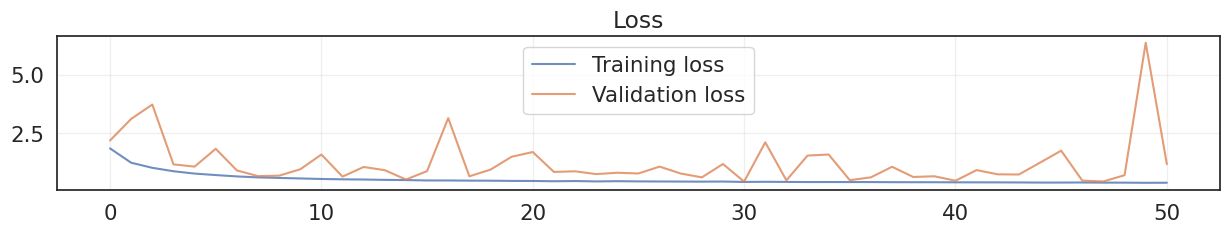

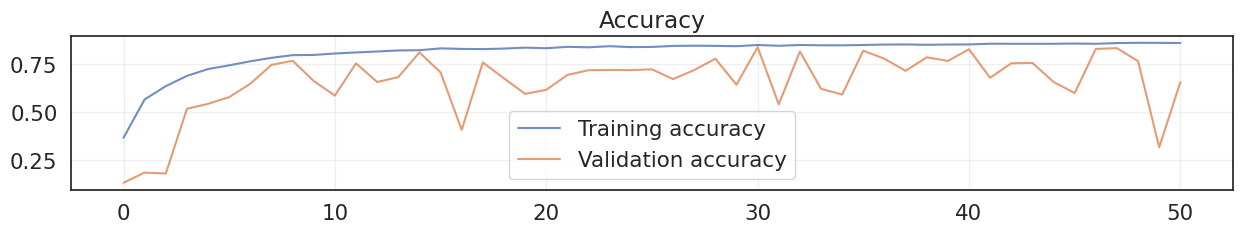

In [25]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

<h3> Model Analysis </h3>
<hr>

In [26]:
# Load the saved model
model = tfk.models.load_model('BLOOD_CNN_TEST_83.81.keras')

In [28]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1376, 8)


In [29]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
#plt.figure(figsize=(10, 8))
#sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_name.values()), yticklabels=list(class_name.values()), cmap='Blues')
#plt.xlabel('True labels')
#plt.ylabel('Predicted labels')
#plt.show()

Accuracy score over the test set: 0.8321
Precision score over the test set: 0.8861
Recall score over the test set: 0.8321
F1 score over the test set: 0.8447


# Model built using Residual, Senet, and Inception Blocks on Balanced Dataset (up sampling)


In [ ]:
# Set seed for reproducibility
seed = 42

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import matplotlib.gridspec as gridspec

np.random.seed(42)
tf.random.set_seed(42);

## ⏳ Load the Data

In [30]:
# Load the training data here
data = np.load('increased_balanced_dataset_noBrightness_noContrast_noZoom.npz')
X = data['images']
y = data['labels']

In [31]:
class_name = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [32]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state=seed
)

<h3> Data Normalization and Encoding </h3>
<hr>

In [33]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [34]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (13580, 96, 96, 3)
Training Label Shape: (13580, 8)
Validation Data Shape: (3395, 96, 96, 3)
Validation Label Shape: (3395, 8)


In [35]:

# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))
print('Classification: ', class_name[np.argmax(y_train[0])])

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 6
Classification:  Neutrophil


<h3> Input and Output Shape </h3>
<hr>

In [36]:
# Determine the input shape, corresponding to the number of features
input_shape = X_train.shape[1:]
print(f'Input shape of the network {input_shape}')

# Determine the output shape, corresponding to the number of classes
output_shape = y_train.shape[1]
print(f'Output shape of the network {output_shape}')

Input shape of the network (96, 96, 3)
Output shape of the network 8


<h3> Other Parameters Definition </h3>
<hr>

In [37]:
# Learning rate?: step size for updating the model's weights
learning_rate = 0.001

# Define the batch size for training
batch_size = 64

# Define the number of training epochs
epochs = 1000

# Create an empty dictionary to store metadata
metadata = {}

## 🛠️ Train and Save the Model

In [ ]:
# Define the Inception block with BN and with multiple convolution paths and optional downsampling
def inception_block_bn(x, filters, kernel_size=3, padding='same',
                       downsample=True, activation='relu', stack=2, name='inception'):
    # Loop through specified stack layers for multiple inception paths
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [ ]:
# Define an inception blocks fllowed by SENet block with configurable parameters
def senet_inception_block(x, filters, kernel_size=3, padding='same',
                downsample=True, activation='relu', stack=2, name='senet'):

    for s in range(stack):
        # Main convolutional path
        x = inception_block_bn(x, filters, kernel_size, padding='same',
                   downsample=False, activation='relu', stack=1, name='residual'+name)

        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:
# Define the Residual block with configurable parameters.
# One other architecture trial for the model was to include a inception followed by a senet block in a residual block
def residual_senet_inception_block(x, filters=64, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=2, name='residual_senet_inception'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = senet_inception_block(x, filters, kernel_size=kernel_size, padding='same',
                       downsample=False, activation='relu', stack=1, name='inception'+name)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [38]:
tf.random.set_seed(seed)

# Build the neural network layer by layer
inputs = tfkl.Input(shape=input_shape, name='Input')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip(),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.5),
    tfkl.RandomZoom(0.0, .1),
#    tfkl.RandomBrightness(0.5, value_range=(0,1)),
#    tfkl.RandomContrast(0.75),
], name='Augmentation')

x = augmentation(inputs)

x = residual_senet_inception_block(x, filters=16, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception1')

x = residual_senet_inception_block(x, filters=32, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception2')

x = residual_senet_inception_block(x, filters=64, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=1, name='residual_senet_inception3')

# Global Average Pooling and fully connected output layer
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(0.5, name='dropout')(x)
x = tfkl.Dense(output_shape, name='dense')(x)
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [39]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Augmentation           │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_flip_1     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomFlip)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ random_translation_1   │                      │              │                     │         │
│ (RandomTranslation)    │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_rotation_1 │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomRotation)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ random_zoom_1     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (RandomZoom)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            8 │ Augmentation[0][0]  │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            4 │ Augmentation[0][0]  │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            8 │ residualinceptionr… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            4 │ residualinceptionr… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 2)    │            0 │ residualinceptionr… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 1)    │            0 │ residualinceptionr… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ residualinceptionresi… │ (None, 96, 96, 3)    │            0 │ Augmentation[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 10,986 (42.91 KB)

 Trainable params: 10,494 (40.99 KB)

 Non-trainable params: 492 (1.92 KB)

In [40]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [41]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BLOOD_CNN_TEST_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.2874 - loss: 2.0973 - val_accuracy: 0.1237 - val_loss: 2.7503
Epoch 2/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.5733 - loss: 1.1497 - val_accuracy: 0.2427 - val_loss: 3.9868
Epoch 3/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.6865 - loss: 0.8680 - val_accuracy: 0.6015 - val_loss: 1.0608
Epoch 4/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7429 - loss: 0.7305 - val_accuracy: 0.5426 - val_loss: 1.2853
Epoch 5/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.7688 - loss: 0.6567 - val_accuracy: 0.4551 - val_loss: 1.4916
Epoch 6/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.7878 - loss: 0.6091 - val_accuracy: 0.5891 - val_loss: 1.4088
Epoch 7/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.8022 - loss: 0.5553 - val_accuracy: 0.5446 - val_loss: 1.3368
Epoch 8/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8137 

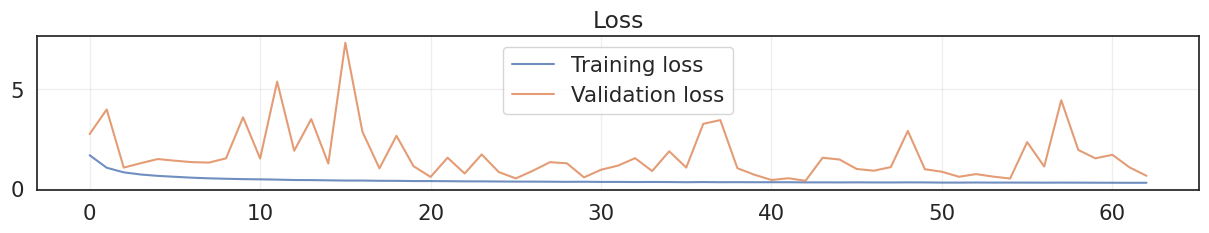

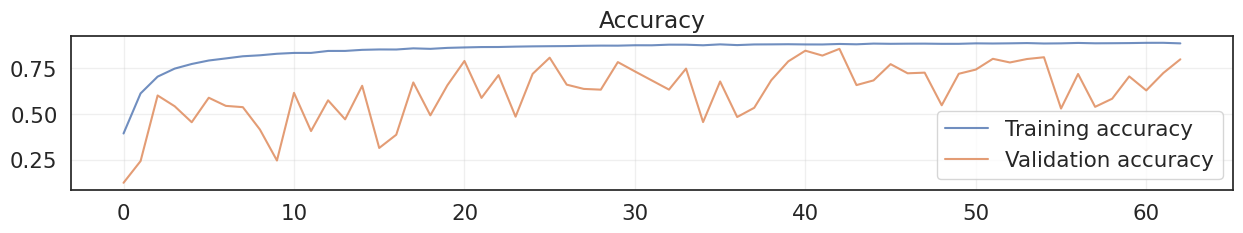

In [42]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

<h3> Model Analysis </h3>
<hr>

In [43]:
# Load the saved model
model = tfk.models.load_model('BLOOD_CNN_TEST_85.66.keras')

In [44]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1887, 8)


Accuracy score over the test set: 0.8516
Precision score over the test set: 0.8988
Recall score over the test set: 0.8516
F1 score over the test set: 0.8626


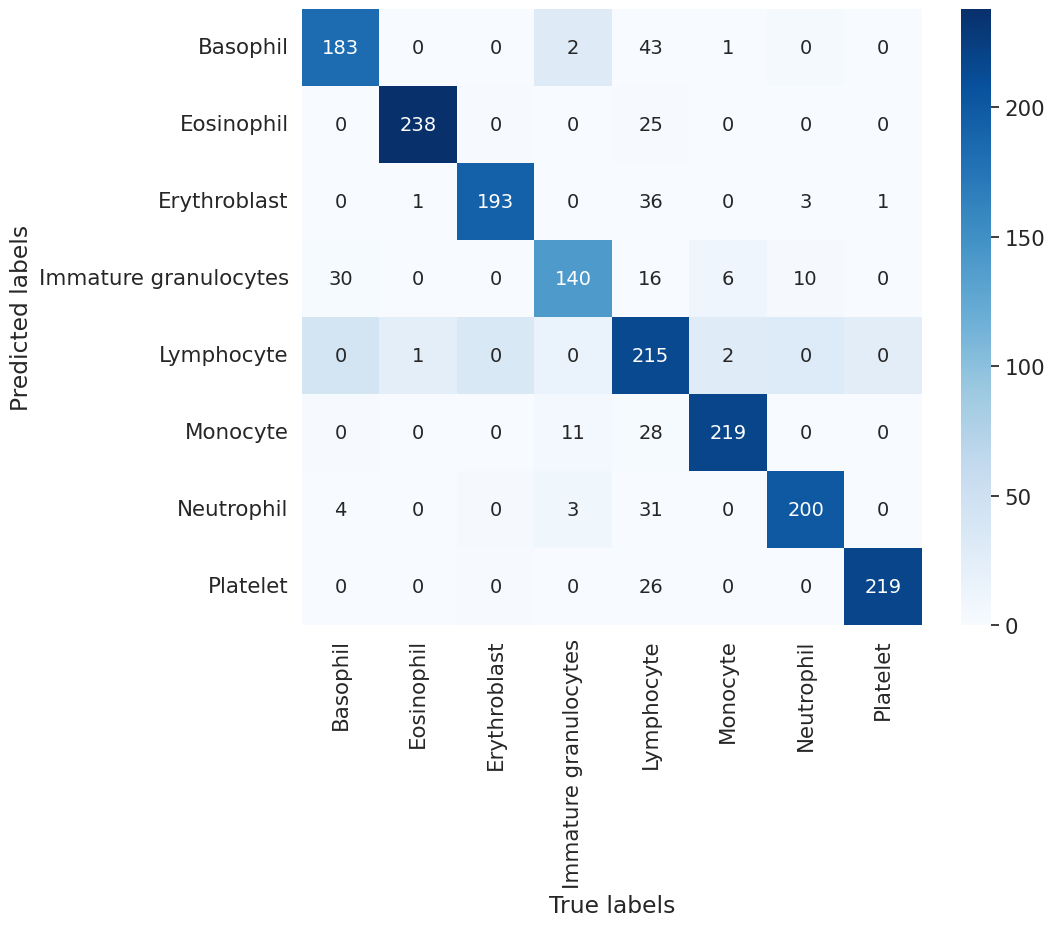

In [46]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_name.values()), yticklabels=list(class_name.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()